# Probabilites Stock Price Nvidia 
We plot a pdf $f(x)$ for the Nvidia stock, which illustrates how likeley it is that the Nvidia reaches price $x >0 $ at various dates based on various option prices at different strikes $K$ and different expiry dates.

In [1]:
import numpy as np
from random import gauss
import datetime
import yfinance as yf
import pandas as pd
import matplotlib .pyplot as plt
from matplotlib import cbook, cm
from matplotlib.colors import LightSource   
from arch import arch_model
from arch.univariate import EGARCH
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tabulate import tabulate
import itertools
from matplotlib import cm
from matplotlib.dates import date2num, num2date,DateFormatter


%matplotlib widget

Let us first fix the expiry dates and the strikes which we want to consider in our analysis.

In [2]:
ticker = yf.Ticker("NVDA")
expiry_dates = ticker.options

In [3]:
expiry_dates = expiry_dates

We gather all the strikes, for which we have a listed call and put option at each of the listed expiry dates 

In [4]:
possibleStrikes = set(ticker.option_chain(expiry_dates[0]).calls["strike"])


for i in range(len(expiry_dates)):
    strikes_Call = set(ticker.option_chain(expiry_dates[i]).calls["strike"])
    strikes_Put = set(ticker.option_chain(expiry_dates[i]).puts["strike"])
    possibleStrikes = possibleStrikes.intersection(strikes_Call)
    possibleStrikes = possibleStrikes.intersection(strikes_Put)

possibleStrikes = sorted(list(possibleStrikes))

The PDF for the probability 
$F_T(x) = P(S_T < x ) = {p_T \over p_T + c_T}$
where $S_T$ is the stock price at time $T$ (which needs to be listed in our expiry dates), $p_T$ is our put option market price and $c_T$ is our call option market price.

In [5]:
pdf_how_likeley_Stock_Under_Strike = np.zeros((len(expiry_dates), len(possibleStrikes)))
for i in range(len(expiry_dates)):
    callsForThisExpiry = ticker.option_chain(expiry_dates[i]).calls
    putsForThisExpiry = ticker.option_chain(expiry_dates[i]).puts
    for j in range(len(possibleStrikes)):
        callsPrice =  callsForThisExpiry[callsForThisExpiry['strike'] == possibleStrikes[j]]["lastPrice"].item()
        putPrice =  putsForThisExpiry[putsForThisExpiry['strike'] == possibleStrikes[j]]["lastPrice"].item()
        pdf_how_likeley_Stock_Under_Strike[i,j] = putPrice/(putPrice +callsPrice)


Compute
$\tilde F_T(x) = P(S_T > x) = 1- F_T(x)$

In [11]:
pdf_how_likeley_Stock_Above_Strike = 1 - pdf_how_likeley_Stock_Under_Strike

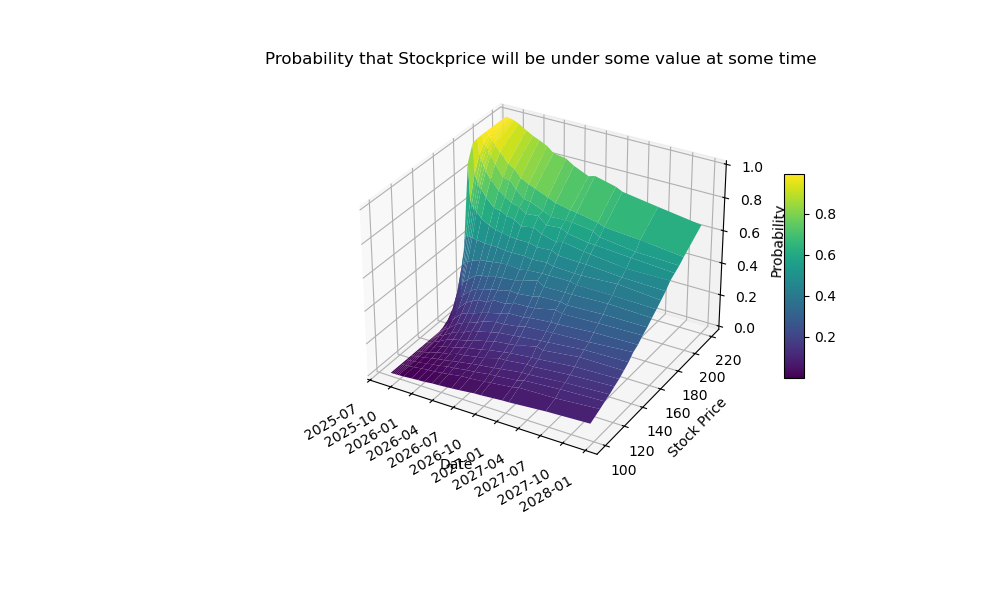

In [7]:
x = np.array(expiry_dates)

y = possibleStrikes

x_dates = np.array([datetime.datetime.strptime(d, "%Y-%m-%d") for d in expiry_dates])
x_num = date2num(x_dates)
X, Y = np.meshgrid(x_num, y, indexing="ij")  # shape (N,M)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(X, Y, pdf_how_likeley_Stock_Under_Strike, cmap=cm.viridis)

ax.xaxis_date()
fig.autofmt_xdate()
ax.set_title("Probability that Stockprice will be under some value at some time")
ax.set_xlabel("Date")
ax.set_ylabel("Stock Price")
ax.set_zlabel("Probability")

plt.colorbar(surf, shrink=0.5, aspect=10)
plt.show()

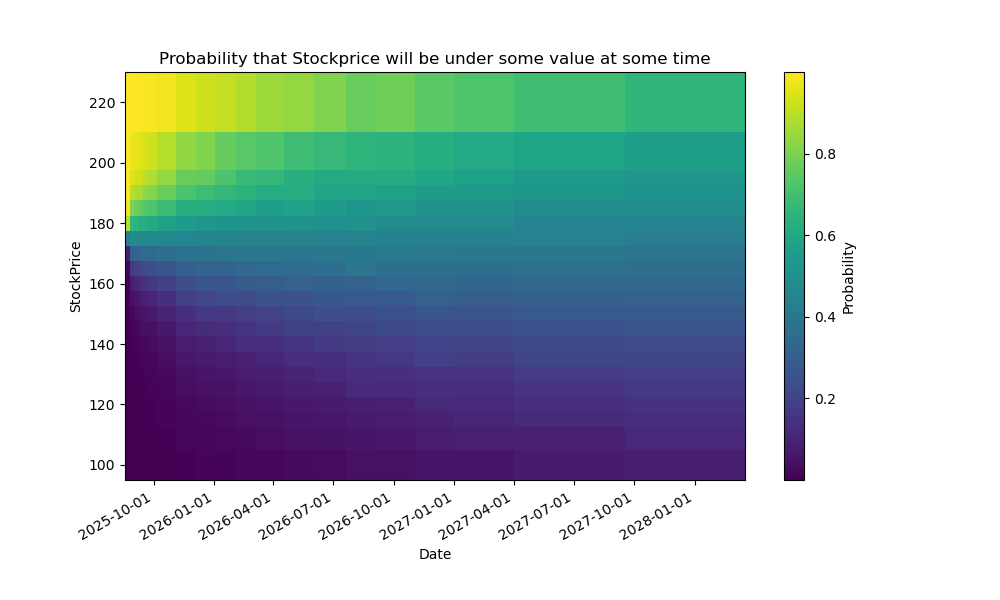

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

c = ax.pcolormesh(X, Y, pdf_how_likeley_Stock_Under_Strike, cmap="viridis", shading="auto")

ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
fig.autofmt_xdate()

ax.set_title("Probability that Stockprice will be under some value at some time")
ax.set_xlabel("Date")
ax.set_ylabel("StockPrice")
plt.colorbar(c, ax=ax, label="Probability")

plt.show()

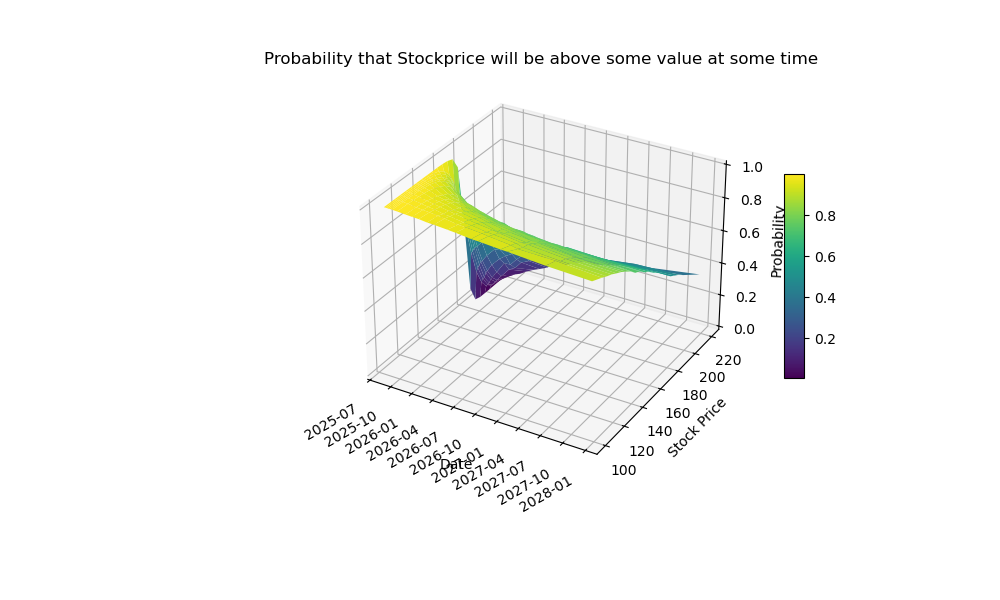

In [9]:
x = np.array(expiry_dates)

y = possibleStrikes


x_dates = np.array([datetime.datetime.strptime(d, "%Y-%m-%d") for d in expiry_dates])
x_num = date2num(x_dates)
X, Y = np.meshgrid(x_num, y, indexing="ij")  # shape (N,M)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(X, Y, pdf_how_likeley_Stock_Above_Strike, cmap=cm.viridis)

ax.xaxis_date()
fig.autofmt_xdate()
ax.set_title("Probability that Stockprice will be above some value at some time")
ax.set_xlabel("Date")
ax.set_ylabel("Stock Price")
ax.set_zlabel("Probability")

plt.colorbar(surf, shrink=0.5, aspect=10)
plt.show()

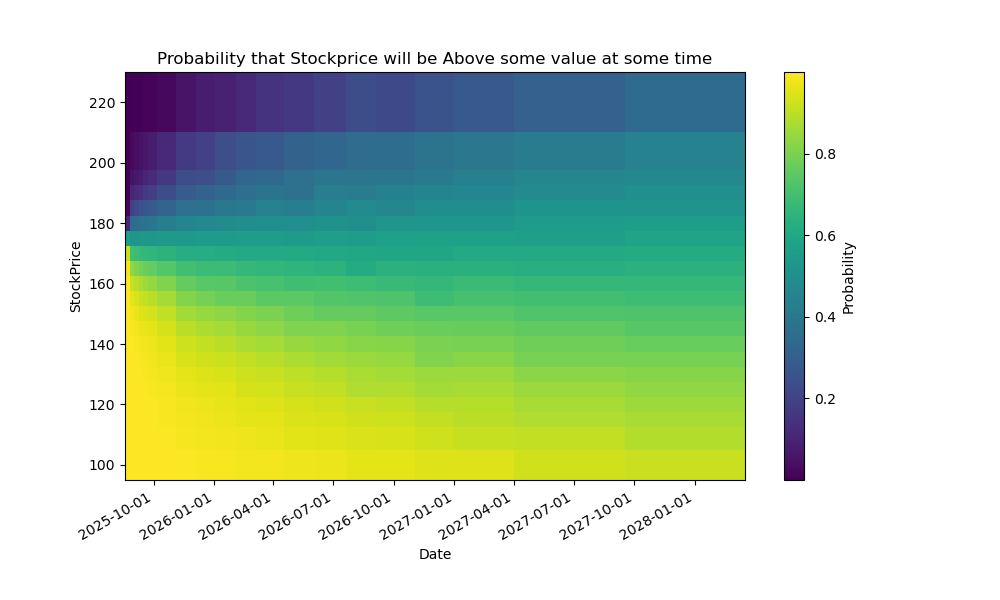

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))


c = ax.pcolormesh(X, Y, pdf_how_likeley_Stock_Above_Strike, cmap="viridis", shading="auto")

ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
fig.autofmt_xdate()

ax.set_title("Probability that Stockprice will be Above some value at some time")
ax.set_xlabel("Date")
ax.set_ylabel("StockPrice")
plt.colorbar(c, ax=ax, label="Probability")

plt.show()